In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stix2.v21 import (ThreatActor, Identity, AttackPattern, Campaign, IntrusionSet, Relationship, ExternalReference, Bundle, Grouping)
from efficient_apriori import apriori
import re
from pyattck import Attck
import requests
from stix2 import MemoryStore, Filter

In [103]:
# Settings Values - for Apriori Algorithm
# TODO - 2: Do we need to adjust these numbers, in order to refine our algorithm metrics??
confidenceLevel = 0.70
supportLevel = 0.05
abstract = False

In [104]:
def GenerateAprioriLists():
    # TODO - 2: Do we need to retrain this data on a new dataset? How can we do this?
    # Some data comes from this dataset with TTPs
    df = pd.read_csv("datasets/Categorized_Adversary_TTPs.csv") # sample dataset of attacks
    
    # More data is gained by using attck data from tool and malware TTPs
    attack = Attck()
    
    malwares = attack.enterprise.malwares + attack.enterprise.tools
    ttpLists = []
    for malware in malwares:
        ttpLists.append(["'" + ttp.id + "'" for ttp in malware.techniques])

    # To use the apriori we need to generate a list of lists
    aprList = ttpLists
    for row in df.values:
        aprList.append((row[13].strip('][').split(', ')))
    return aprList

In [105]:
def AbstractTTPs(ttpList):
    # Take sub-techniques and remove the .### to abstract them to parent techniques 
    for i in range(0,len(ttpList)):
        ttpList[i] = [re.sub(r'\.[0-9]+', '', ttp) for ttp in ttpList[i]]
    return ttpList 

In [106]:
# takes a list of lists and returns a list of rules sorted by size 
def AprioriMining(aprList):
    # Perform apriori rule association mining
    itemsets, rules = apriori(aprList, min_support=supportLevel, min_confidence=confidenceLevel)
    
    # Sort by size to get the 1:1 mappings first and so on. 
    ruleNums = np.array([len(rule.lhs+rule.rhs) for rule in rules])
    rules = np.array(rules)
    inds = ruleNums.argsort()[::]
    rules = rules[inds]
    
    # Maximum rule size of 4 to limit number of rules, any rules with size > 4 are redundant anyways
    rules = [x for x in filter(lambda rule: len(rule.lhs+rule.rhs) <= 4, rules)]
    return rules

In [107]:
# Downloads latest MITRE framework from the branch
def get_data_from_branch(domain):
    """get the ATT&CK STIX data from MITRE/CTI. Domain should be 'enterprise-attack', 'mobile-attack' or 'ics-attack'. Branch should typically be master."""
    stix_json = requests.get(f"https://raw.githubusercontent.com/mitre-attack/attack-stix-data/master/{domain}/{domain}.json").json()
    return MemoryStore(stix_data=stix_json["objects"])

src = get_data_from_branch("enterprise-attack")

In [108]:
# Get TTPs from seed, where seed is an APT group code: GXXXX
def ExtractSeedTTPs(seed):
    seeds = []
    # This runs but says that "actors" is not found
    actor = actors[seed]
    for ttp in actor.techniques:
        seeds.append(ttp.id)
        
    # If we are using abstracted TTPs then remove sub technique
    if (abstract):
        for i in range(0, len(seeds)):
            seeds[i] = re.sub(r'\.[0-9]+', '', seeds[i])
    return seeds

In [109]:
def ExportBundle(bundle, filename):
    with open(filename, "w") as f:
        f.write(bundle.serialize())
        f.close()

In [110]:
# Each rule has a confidence, lift, support, lhs, rhs, conviction, rule power factor (RPF), 

# Takes an APTGroup and generates hypothesized relationships and attack pattern objects
# Returns a tuple of: (profile, attackPatterns, relationships, groupings)
def CreateRelationships(seeds, aprioriLists):
    profile = {} #stores the TTP and tactic for easy logging
    seen = [] #stores TTPs that have been seen by the algorithm
    attackPatterns = [] #stores generated attack pattern objects
    relationships = {} # stores generated relationship objects
    groupings = {} # stores generated grouping objects

    # Get seeds out of the APT group
    # seeds = ExtractSeedTTPs(APTGroup)
    # seeds = ["T1566", "T1204"]
    
    # Perform Association Rule Mining
    rules = AprioriMining(aprioriLists) 
    
    # Add seeds to activity-attack-graph as nodes
    for seed in seeds:
        profile[seed] = 1
        # Get the stix object for the TTP
        ttp = src.query([ Filter("external_references.external_id", "=", seed) ])[0]
        
        # Create and add objects to lists, context is used to identify seeds from hypothesized events
        groupings[seed] = (Grouping(object_refs=[ttp.id], context = "Seed Event"))
        attackPatterns.append(src.query([ Filter("external_references.external_id", "=", seed) ])[0])
    
    # print(profile)
    
    seedTotals = ["'"+x+"'" for x in seeds]
    # Use a queue to iterate through and create a tree of TTPs
    while len(seeds) > 0:
        for rule in rules:
            # Check to see if the left hand side of a rule is satisfied 
            if "'"+seeds[0]+"'" in rule.lhs and set(rule.lhs).issubset(seedTotals):
                # If the lhs is satisfied, then loop through each TTP in the rhs 
                for ttpName in rule.rhs:
                    # If this TTP hasn't been visited already then create STIX objects
                    if ttpName not in seen:
                        ttp = src.query([ Filter("external_references.external_id", "=", ttpName[1:-1]) ])[0]
                        
                        # rule tactics 
                        tactics = []
                        for i in ttp['kill_chain_phases']:
                            tactics.append(i['phase_name'])
                        
                        # create a new grouping object with the rule name. 
                        groupings[ttpName[1:-1]] = (Grouping(object_refs=[ttp.id], context = "Hypothesized Event"))
                        
                        attackPatterns.append(ttp)
                        seedTotals.append(ttpName)
                        seen.append(ttpName)
                        seeds.append(ttp['external_references'][0]['external_id'])

                    # if the relationship already exists between two objects then we take the one with higher confidence
                    # make sure the exact relationship does not alraedy exist
                    if not (groupings[seeds[0]]['id'], groupings[ttpName[1:-1]]['id']) in relationships:
                        # if the opposite relationship exists then choose the one with the highest confidence to add
                        # we do this because if we do not then on the graph there will be two arrows going opposite directions to connect the same 2 TTPs
                        # this causes clutter and makes the confidence values unreadable since they will be layered on top of each other
                        if (groupings[ttpName[1:-1]]['id'], groupings[seeds[0]]['id']) in relationships:
                            # if existing relationship has higher confidence, move on
                            if float(relationships[(groupings[ttpName[1:-1]]['id'], groupings[seeds[0]]['id'])]['relationship_type']) > rule.confidence:
                                continue # move to next iteration of for loop, so code after this statement won't execute
                            # if existing relationship has lower confidence, delete it and let the new relationship take it's place
                            else:
                                del relationships[(groupings[ttpName[1:-1]]['id'], groupings[seeds[0]]['id'])]
                        relationships[(groupings[seeds[0]]['id'], groupings[ttpName[1:-1]]['id'])] = Relationship(groupings[seeds[0]]['id'], str(round(rule.confidence, 3)), groupings[ttpName[1:-1]]['id'])
                        if not((ttpName[1:-1] in profile.keys() and profile[ttpName[1:-1]] >= 1)):
                            profile[ttpName[1:-1]] = round(rule.confidence, 3)
 
        # pop to progress the queue
        seeds.pop(0) 
    
    for seed in seeds:
        profile[seed] = 1
        

    return (profile, attackPatterns, relationships, groupings)

In [111]:
aprioriList = AbstractTTPs(GenerateAprioriLists()) # generate lists for apriori

In [112]:
# 
intelSeed = ["T1566", "T1204"] # Use-case: Observed TTPs
profile, attackPatterns, relationships, groupings = CreateRelationships(intelSeed, aprioriList)

In [113]:
# Displays the results of the Apiori Algorithm 
print(profile)

# This is the hypothesized profile
apt_x = profile

{'T1566': 1, 'T1204': 1, 'T1059': 0.752, 'T1105': 0.74, 'T1027': 0.751, 'T1071': 0.778, 'T1082': 0.819, 'T1547': 0.745, 'T1140': 0.745, 'T1057': 0.753, 'T1083': 0.78, 'T1070': 0.7}


In [114]:
# Bundle STIX Objects for Visualization
bundle = Bundle(attackPatterns+list(groupings.values())+list(relationships.values()), allow_custom=True)

In [115]:
# Export bundle for visualization here: https://github.com/yukh1402/cti-stix-diamond-activity-attack-graph
ExportBundle(bundle, "test.json")

In [116]:
# Phase 2: Make APT Threat Profiles
attack = Attck()

# Dictionary to hold all the threat profiles. 
# The key is a given APT and the values are a list of TTPs
threat_profiles = {}

for actor in attack.enterprise.actors:
    technique_dict = {}
    for technique in actor.techniques:
        technique_dict[technique.id[0:5]] = 1
    threat_profiles[actor.id] = technique_dict
    
print(threat_profiles["G0085"])


# TODO: Add extended_threat profiles
# Create threatprofile Seed -- need to parse the value of the keys.
extended_threat_profiles = {}
for apt, t_codes in threat_profiles.items():
    ttp_list = list(t_codes.keys())
    profile, attackPatterns, relationships, groupings = CreateRelationships(ttp_list, aprioriList)
    extended_threat_profiles[apt] = profile

print(extended_threat_profiles["G0085"])

# TODO: Add progress bar??


{'T1114': 1, 'T1078': 1, 'T1566': 1, 'T1056': 1, 'T1204': 1, 'T1059': 1, 'T1564': 1, 'T1071': 1, 'T1090': 1}
{'T1114': 1, 'T1078': 1, 'T1566': 1, 'T1056': 1, 'T1204': 1, 'T1059': 1, 'T1564': 1, 'T1071': 1, 'T1090': 1, 'T1105': 0.757, 'T1027': 0.745, 'T1547': 0.769, 'T1082': 0.776, 'T1083': 0.759, 'T1070': 0.714, 'T1057': 0.741, 'T1113': 0.704, 'T1033': 0.741, 'T1140': 0.719, 'T1016': 0.732}


In [117]:
# Phase 2: WEIGHTED JACCARD SIMILARITY
# Side note: Find a way to relate techniques and sub-techniques. 

# TODO: Create a function that compares two threat profiles and produces a Weighted Jaccard. Just returns a number. 
def weighted_jac (profile1, profile2):

    # Extract the keys as sets
    keys1 = set(profile1.keys())
    keys2 = set(profile2.keys())

    # Calculate the Jaccard index
    # Only need the normal intersection and union
    intersection = keys1.intersection(keys2)
    union = keys1.union(keys2)
    # jaccard_index = len(intersection) / len(union)

    # Weight the Jaccard index by the values in the dictionaries
    weighted_intersection = sum(min(profile1[k], profile2[k]) for k in intersection)
    weighted_union = sum(max(profile1.get(k, 0), profile2.get(k, 0)) for k in union)
    weighted_jaccard_index = weighted_intersection / weighted_union
    
    return weighted_jaccard_index
    #print("Weighted Jaccard index:", weighted_jaccard_index)


# AAG APT
#p1 = {'T1566': 0.836, 'T1204': 0.944, 'T1059': 0.752, 'T1105': 0.74, 'T1027': 0.751, 'T1071': 0.778, 'T1082': 0.819, 'T1547': 0.745, 'T1140': 0.745, 'T1057': 0.753, 'T1083': 0.78, 'T1070': 0.7}
# Known APT: G0085
#p2 = {'T1114': 1, 'T1078': 1, 'T1566': 1, 'T1056': 1, 'T1204': 1, 'T1059': 1, 'T1564': 1, 'T1071': 1, 'T1090': 1}

# weighted_jac(p1, p2)

In [134]:
# TODO: Create another function that calls the previous function on all of the threat profiles and our threat profile of interest.
# We could do some sort of ranking like list the APTs with the highest Weighted Jaccard first. 
def compare_apt(h_threatprofile, threat_profiles):
    # Make another dictionary 
    rankings = {}
    
    for key, value in threat_profiles.items(): 
        similarity  = (weighted_jac(value, h_threatprofile)) * 100
        percentage = round(similarity, 2)
        rankings[key] = percentage
    
    return rankings

In [136]:
compare_apt_dict = compare_apt(apt_x, extended_threat_profiles)

# SORTED -- NICE!
sorted_dict = dict(sorted(compare_apt_dict.items(), key=lambda x: x[1], reverse=True))
print(sorted_dict)


{'G0103': 95.25, 'G0013': 95.25, 'G0062': 88.46, 'G0066': 77.53, 'G0133': 76.34, 'G0005': 76.12, 'G0137': 74.86, 'G0136': 74.58, 'G0084': 68.81, 'G0048': 67.98, 'G0075': 67.17, 'G0079': 66.87, 'G0130': 65.98, 'G0089': 64.23, 'G0090': 63.65, 'G0029': 62.7, 'G0107': 60.06, 'G0099': 59.36, 'G1007': 57.23, 'G0021': 57.11, 'G0140': 56.71, 'G0095': 56.61, 'G0112': 56.2, 'G0127': 55.46, 'G0024': 55.08, 'G0085': 54.76, 'G1003': 54.61, 'G0056': 53.58, 'G0078': 52.96, 'G0098': 52.91, 'G0070': 52.87, 'G0120': 52.36, 'G0134': 52.06, 'G1011': 51.52, 'G0018': 51.5, 'G0115': 51.42, 'G0138': 47.36, 'G0068': 46.96, 'G0086': 46.4, 'G0142': 46.25, 'G0041': 46.16, 'G0043': 45.71, 'G0019': 45.46, 'G0073': 45.23, 'G0044': 45.0, 'G0124': 44.93, 'G1008': 44.73, 'G0026': 42.57, 'G0131': 42.02, 'G1002': 41.53, 'G0036': 40.86, 'G1005': 40.81, 'G0071': 40.68, 'G0033': 40.25, 'G0119': 39.82, 'G0100': 39.07, 'G0121': 39.03, 'G0051': 38.8, 'G0009': 38.78, 'G0012': 38.32, 'G0052': 38.2, 'G0128': 38.0, 'G0008': 37.36,

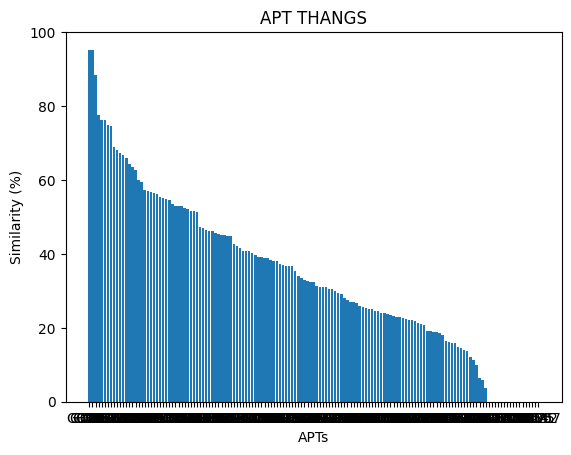

In [137]:
# Make some sort of visualization
import matplotlib.pyplot as plt

# Example dictionary
data = sorted_dict

# Extract keys and values from dictionary
labels = list(data.keys())
values = list(data.values())

# Create a bar chart using matplotlib
plt.bar(labels, values)

# Set chart title and axis labels
plt.title('APT THANGS')
plt.xlabel('APTs')
plt.ylabel('Similarity (%)')

# Display the chart
plt.show()


In [120]:
# Write the dictionary to a JSON file
import json

with open("Extended_Threat_Profiles", "w") as outfile:
    json.dump(extended_threat_profiles, outfile)
    
# Ahhhhh purrrrrr (pian)